In [1]:
import autograd 

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

import sys
sys.path.insert(0, '../')

import structure_model_lib
import data_utils
import paragami

import LinearResponseVariationalBayes.ExponentialFamilies as ef

In [2]:
from BNP_modeling import cluster_quantities_lib, modeling_lib
import BNP_modeling.optimization_lib as opt_lib
import cavi_lib

from itertools import permutations

import matplotlib.pyplot as plt
%matplotlib inline  

import vittles

from copy import deepcopy

In [3]:
np.random.seed(53453)

# Draw data

In [4]:
n_obs = 40
n_loci = 50
n_pop = 4

# population allele frequencies
true_pop_allele_freq = np.random.random((n_loci, n_pop))

# individual admixtures
true_ind_admix_propn = np.random.dirichlet(np.ones(n_pop) / n_pop, size = (n_obs))

In [5]:
clustering_indx = data_utils.cluster_admix_get_indx(true_ind_admix_propn)
true_ind_admix_propn = true_ind_admix_propn[clustering_indx, :]

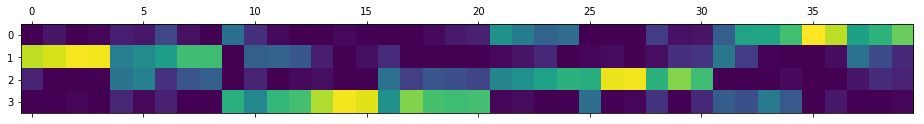

In [6]:
plt.matshow(true_ind_admix_propn.T)

In [7]:
g_obs = data_utils.draw_data(true_pop_allele_freq, true_ind_admix_propn)

In [8]:
g_obs.shape

(40, 50, 3)

# Get prior

In [9]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [10]:
use_logitnormal_sticks = False

In [11]:
k_approx = 12

In [12]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [13]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx, use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (50, 12, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (40, 11, 2) (lb=0.0, ub=inf)


## Initialize 

In [14]:
vb_params_dict = structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict, 
                                                        use_logitnormal_sticks)

In [15]:
# take a look at init 
if use_logitnormal_sticks: 
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                        vb_params_dict['ind_mix_stick_propn_mean'], 
                        vb_params_dict['ind_mix_stick_propn_info'],
                        gh_loc, gh_weights)

else: 
    # take a look at init 
    ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
    e_stick_lengths = \
            modeling_lib.get_e_beta(ind_mix_stick_beta_params)
    e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])

In [16]:
if k_approx < 6: 
    # find minimizing permutation 
    # only feasible if k_approx is small, 
    # else my computer freezes
    perm = data_utils.find_min_perm(e_pop_freq, true_pop_allele_freq, axis = 1)
else: 
    perm = np.arange(k_approx)
    
e_pop_freq = e_pop_freq[:, perm]
e_ind_admix = e_ind_admix[:, perm]

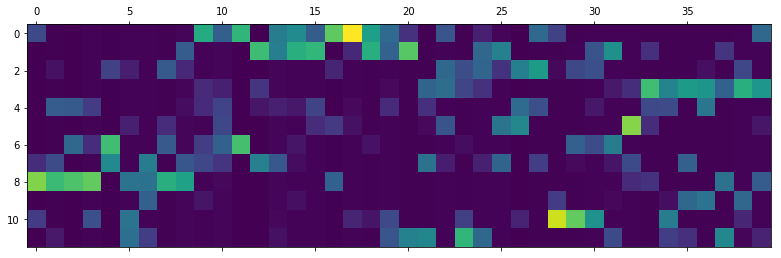

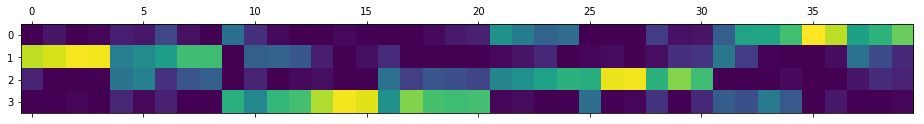

In [17]:
plt.matshow(e_ind_admix.T); 
plt.matshow(true_ind_admix_propn.T);

# Run CAVI

In [18]:
e_log_sticks, e_log_1m_sticks, \
    e_log_pop_freq, e_log_1m_pop_freq = \
        structure_model_lib.get_moments_from_vb_params_dict(g_obs, vb_params_dict, use_logitnormal_sticks)

In [19]:
e_z, stick_beta_params, pop_beta_params = \
    cavi_lib.run_cavi(g_obs, e_log_pop_freq, e_log_1m_pop_freq,
                e_log_sticks, e_log_1m_sticks,
                prior_params_dict, 
                max_iter = 2000, f_tol = 1e-2)

iteration [0]; kl:5236.374799
iteration [1]; kl:4250.381652
iteration [2]; kl:4093.300575
iteration [3]; kl:4041.217246
iteration [4]; kl:4007.64126
iteration [5]; kl:3980.540426
iteration [6]; kl:3957.102266
iteration [7]; kl:3936.173486
iteration [8]; kl:3917.053787
iteration [9]; kl:3899.245681
iteration [10]; kl:3882.414804
iteration [11]; kl:3866.359208
iteration [12]; kl:3850.976535
iteration [13]; kl:3836.242301
iteration [14]; kl:3822.194346
iteration [15]; kl:3808.911121
iteration [16]; kl:3796.479271
iteration [17]; kl:3784.953301
iteration [18]; kl:3774.32465
iteration [19]; kl:3764.526307
iteration [20]; kl:3755.463875
iteration [21]; kl:3747.035584
iteration [22]; kl:3739.138097
iteration [23]; kl:3731.676191
iteration [24]; kl:3724.577592
iteration [25]; kl:3717.807548
iteration [26]; kl:3711.371652
iteration [27]; kl:3705.293101
iteration [28]; kl:3699.572468
iteration [29]; kl:3694.163697
iteration [30]; kl:3688.985868
iteration [31]; kl:3683.948682
iteration [32]; kl:3

In [20]:
# check results after CAVI steps

In [21]:
if use_logitnormal_sticks: 
    # convert beta params to logitnormal
    raise NotImplementedError()
else: 
    vb_params_dict['pop_freq_beta_params'] = pop_beta_params
    vb_params_dict['ind_mix_stick_beta_params'] = stick_beta_params

In [22]:
e_pop_allele_freq = modeling_lib.get_e_beta(pop_beta_params)

In [23]:
if k_approx < 6: 
    perm_best = data_utils.find_min_perm(e_pop_allele_freq, true_pop_allele_freq, axis = 1)
else: 
    perm_best = perm

In [24]:
ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
e_stick_lengths = \
        modeling_lib.get_e_beta(ind_mix_stick_beta_params)
e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)[:, perm_best]

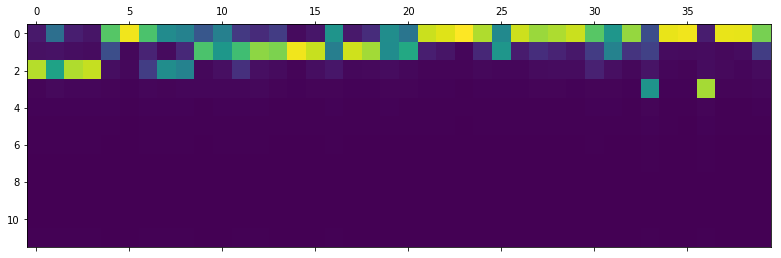

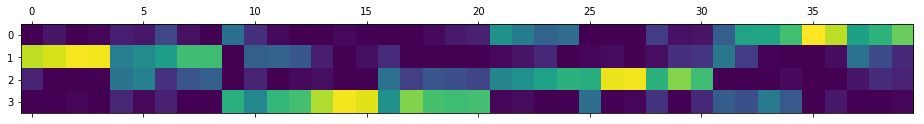

In [25]:
plt.matshow(e_ind_admix.T); 
plt.matshow(true_ind_admix_propn.T);

In [26]:
vb_params_dict_cavi = deepcopy(vb_params_dict)

# run a few Netwon steps

In [27]:
# get loss as a function of vb parameters
get_free_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=structure_model_lib.get_kl, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

get_free_vb_params_loss_cached = \
    lambda x : get_free_vb_params_loss(g_obs, x, prior_params_dict, gh_loc, gh_weights, 
                                       use_logitnormal_sticks)

In [28]:
init_vb_free_params = vb_params_paragami.flatten(vb_params_dict_cavi, free = True)

In [29]:
get_free_vb_params_loss_cached(init_vb_free_params)

3511.880490127629

In [30]:
vb_opt_free_params = opt_lib.optimize_full(get_free_vb_params_loss_cached, init_vb_free_params,
                    bfgs_max_iter = 0, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8,
                    init_hessian = None)


 running preconditioned newton; iter =  0
computing preconditioner 
preconditioning time: 95.74
running newton steps
Iter 0: f = 3511.88049013
Iter 1: f = 3511.79305136
Iter 2: f = 3511.78806107
Iter 3: f = 3511.78802026
Iter 4: f = 3511.78802022
Iter 5: f = 3511.78802022
Optimization terminated successfully.
         Current function value: 3511.788020
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
         Hessian evaluations: 0
Iter 0: x_diff = 15.121666259943513, f_diff = 0.09246990920291864, grad_l1 = 1.2989022614616402e-08
done. 


In [34]:
vb_params_dict_newton = vb_params_paragami.fold(vb_opt_free_params, free = True)

In [40]:
e_pop_allele_freq = modeling_lib.get_e_beta(vb_params_dict_newton['pop_freq_beta_params'])

In [41]:
if k_approx < 6: 
    perm_best = data_utils.find_min_perm(e_pop_allele_freq, true_pop_allele_freq, axis = 1)
else: 
    perm_best = perm

In [42]:
ind_mix_stick_beta_params = vb_params_dict_newton['ind_mix_stick_beta_params']
e_stick_lengths = \
        modeling_lib.get_e_beta(ind_mix_stick_beta_params)
e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)[:, perm_best]

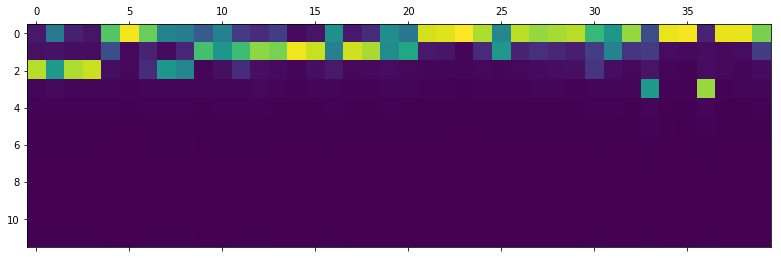

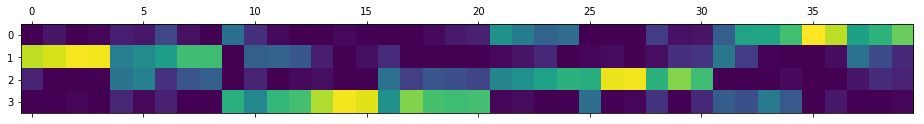

In [43]:
plt.matshow(e_ind_admix.T); 
plt.matshow(true_ind_admix_propn.T);